# Supplementary dynamics Figures

In [1]:
import matplotlib.animation as animation
import numpy as np
import scipy.ndimage as ndi
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import dask.array as da
from dask.distributed import Client, LocalCluster
import os
import xarray as xr

from ipywidgets import interactive
import ipywidgets as widgets
from skimage.morphology import binary_erosion, disk

import zarr
import colorcet

import pyGPA
import pyGPA.geometric_phase_analysis as GPA
try:
    import pyGPA.cuGPA as cuGPA
except ModuleNotFoundError:
    print("No cupy support found!")
import pyGPA.property_extract as pe
from pyGPA.imagetools import gauss_homogenize2

glasbey = plt.get_cmap('cet_glasbey_dark')(np.linspace(0, 1, 255))


def plot_stack2(images, n):
    """Plot the n-th image from a stack of n images.
    For interactive use with ipython widgets"""
    im = images[n, :, :]
    plt.figure(figsize=[12, 12])
    plt.imshow(im.T, cmap='gray')  # , vmax=im.mean()*2)
    plt.show()

In [2]:
%matplotlib inline

In [4]:
cluster = LocalCluster(n_workers=4, threads_per_worker=4, memory_limit='10GB')
client = Client(cluster)
client

/home/tobias/anaconda3/envs/moire-figures/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36243 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:36243/status,
Dashboard: http://127.0.0.1:36243/status,Workers: 4
Total threads: 16,Total memory: 37.25 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36999,Workers: 4
Dashboard: http://127.0.0.1:36243/status,Total threads: 16
Started: Just now,Total memory: 37.25 GiB
Comm: tcp://127.0.0.1:43183,Total threads: 4
Dashboard: http://127.0.0.1:44799/status,Memory: 9.31 GiB
Nanny: tcp://127.0.0.1:38339,


In [27]:
folder = 'data'
name = '20200717_133946_2.3um_480.6_movement_data'

container = xr.open_dataset(os.path.join(folder, name + '.nc'), chunks='auto')
data = container.Intensity.data
NMPERPIXEL = 1.36
container

<xarray.Dataset>
Dimensions:      (time: 119, x: 1287, y: 1035)
Coordinates:
  * time         (time) datetime64[ns] 2020-07-17T13:39:53 ... 2020-07-17T13:...
  * x            (x) float64 0.0 1.36 2.72 ... 1.746e+03 1.748e+03 1.749e+03
  * y            (y) float64 0.0 1.36 2.72 ... 1.404e+03 1.405e+03 1.406e+03
Data variables:
    Intensity    (time, x, y) uint16 dask.array<chunksize=(89, 967, 778), meta=np.ndarray>
    Pressure     (time) float64 dask.array<chunksize=(119,), meta=np.ndarray>
    Multiplier   (time) float64 dask.array<chunksize=(119,), meta=np.ndarray>
    Energy       (time) float64 dask.array<chunksize=(119,), meta=np.ndarray>
    Energy_set   (time) float64 dask.array<chunksize=(119,), meta=np.ndarray>
    Temperature  (time) float64 dask.array<chunksize=(119,), meta=np.ndarray>
Attributes:
    dataset identifier:  20200717_133946_2.3um_480.6_movement

In [6]:
dims = data.shape
xx, yy = np.meshgrid(np.arange(-dims[2]//2, dims[2]//2),
                     np.arange(-dims[1]//2, dims[1]//2))

outer_radius = 640
mask = (xx)**2 + (yy)**2 < outer_radius**2

edge = 20

homogenizesigma = 50

## Create homogenized data

First, we homogenize the data to remove global intensity variations, and write the homogenized stack to disk as zarr.

In [7]:
mdata = np.where(mask, data, np.nan)

mdata = mdata[:, edge:-edge, edge:-edge]
mdata = mdata / np.nanmean(mdata, axis=(1, 2), keepdims=True)

# This call should probably be parallelized by using dask map_blocks or as_gufunc or something similar
ndatag = gauss_homogenize2(mdata,
                           mask[None, edge:-edge, edge:-edge],
                           sigma=[0, homogenizesigma, homogenizesigma])

In [8]:
ndatag

dask.array<truediv, shape=(119, 1247, 995), dtype=float64, chunksize=(89, 947, 758), chunktype=numpy.ndarray>

In [9]:
da.to_zarr(ndatag.rechunk(), os.path.join(folder, name + f'homogenize_s={homogenizesigma}.zarr'), overwrite=True)

## Time direction smooth

To suppress noise, we reread the homogenized data and smooth along the time direction.

In [10]:
tsigma = 1
ndatag = da.from_zarr(os.path.join(folder, name+f'homogenize_s={homogenizesigma}.zarr'))
ndata = ndi.filters.gaussian_filter1d(ndatag, sigma=tsigma,
                                      axis=0, order=0)
interactive(lambda n: plot_stack2(ndata, n),
            n=widgets.IntSlider(1, 0, ndata.shape[0]-1, 1, continuous_update=False)
            )

interactive(children=(IntSlider(value=1, continuous_update=False, description='n', max=118), Output()), _dom_c…

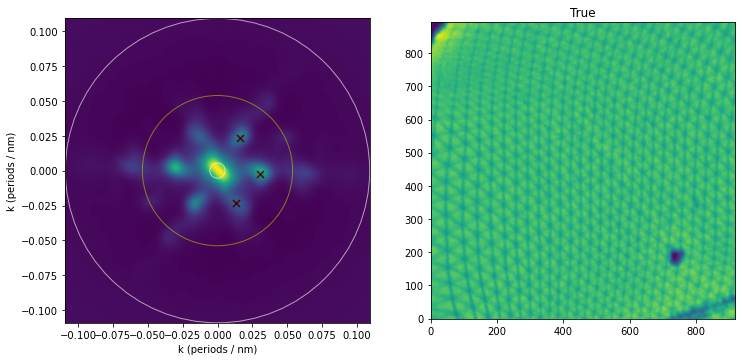

In [12]:
cropped = pyGPA.imagetools.trim_nans2(ndata[0])
pks, _ = GPA.extract_primary_ks(cropped, plot=True, pix_norm_range=(5, 100), sigma=3)

In [13]:
kw = np.linalg.norm(pks, axis=1).mean() / 4
sigma = 20
dr = 2*sigma
kstep = kw/3  # 6
mask = ~np.isnan(ndata[0])
mask = binary_erosion(np.pad(mask, 1), selem=disk(dr))[1:-1, 1:-1]
maskzero = 0.000001

ks = [0, 55, 100]
kw, sigma, dr, kstep

(0.007181197285703718, 20, 40, 0.002393732428567906)

0, 

/home/tobias/anaconda3/envs/moire-figures/lib/python3.8/site-packages/pyGPA/mathtools.py:74: RuntimeWarning: invalid value encountered in remainder
  r = (x+np.pi) % (2*np.pi) - np.pi


55, 

/home/tobias/anaconda3/envs/moire-figures/lib/python3.8/site-packages/pyGPA/mathtools.py:74: RuntimeWarning: invalid value encountered in remainder
  r = (x+np.pi) % (2*np.pi) - np.pi


100, 

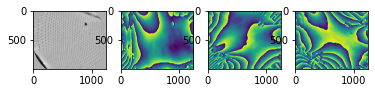

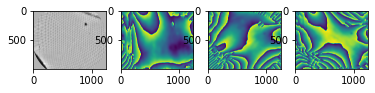

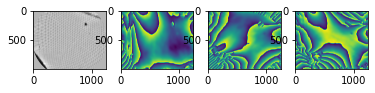

In [14]:
uws = []
for i in ks:
    print(i, end=', ')
    deformed = ndata[i]
    deformed = deformed - np.nanmean(deformed)
    deformed = np.nan_to_num(deformed)
    f, axs = plt.subplots(ncols=4)
    axs[0].imshow(deformed.T, cmap='gray')
    gs = []
    for j, pk in enumerate(pks):
        g = cuGPA.wfr2_grad_opt(deformed, sigma,
                                pk[0], pk[1], kw=kw,
                                kstep=kstep, grad='diff')
        gs.append(g)
        axs[j+1].imshow(np.angle(g['lockin']).T)
    phases = np.stack([np.angle(g['lockin']) for g in gs])
    grads = np.stack([g['grad'] for g in gs])
    weights = np.abs([g['lockin'] for g in gs])*(mask+maskzero)
    u_grad = GPA.reconstruct_u_inv_from_phases(pks, grads[..., ::-1],
                                               # grads,
                                               # -2*np.pi*grads,
                                               weights, pre_diff=True)
    uws.append(u_grad)

In [15]:
# Check that average displacement is 0, i.e. no global movement.
uws = np.array(uws)
uws.mean(axis=(-1, -2))

array([[ 1.86478062e-15, -5.24836054e-16],
       [ 2.93204499e-15,  1.05553620e-15],
       [ 5.09003011e-15, -2.93204499e-18]])

In [16]:
meanshifts = np.nanmean(np.where(mask, uws, np.nan), axis=(-1, -2))
meanshifts - meanshifts[0]

array([[0.        , 0.        ],
       [0.03291242, 0.09062214],
       [0.0524499 , 0.06807247]])

In [17]:
props = []
for u in uws:
    J = pe.u2J(u, NMPERPIXEL)
    prop = pe.Kerelsky_J(J, pks, nmperpixel=NMPERPIXEL, sort=1)[0]
    props.append(prop)

In [18]:
(container.time.data - container.time.data[0]).astype('timedelta64[s]')

array([  0,   2,   5,   8,  10,  13,  16,  19,  22,  24,  27,  30,  33,
        36,  38,  41,  44,  47,  50,  52,  55,  58,  61,  63,  66,  69,
        72,  75,  77,  80,  83,  86,  89,  91,  94,  97, 100, 103, 105,
       108, 111, 114, 116, 119, 122, 125, 128, 130, 133, 136, 139, 142,
       144, 147, 150, 153, 156, 158, 161, 164, 167, 170, 172, 175, 178,
       181, 183, 186, 189, 192, 195, 197, 200, 203, 206, 209, 211, 214,
       217, 220, 223, 225, 228, 231, 234, 237, 239, 242, 245, 248, 250,
       253, 256, 259, 262, 264, 267, 270, 273, 276, 278, 281, 284, 287,
       290, 292, 295, 298, 301, 304, 306, 309, 312, 315, 317, 320, 323,
       326, 329], dtype='timedelta64[s]')

In [19]:
dts = (container.time.data - container.time.data[0]).astype('timedelta64[s]')
clim = np.nanquantile(ndata-ndata[0], [0.9999, 0.0001])
clim = [0.05, -0.05]

In [20]:
clim2 = da.percentile(ndatag[~np.isnan(ndatag)].flatten(), [0.1, 99.9]).compute()

## Generate displacement data. Takes a while and requires in the current format a working cuda installation!

This data is also included in the [data
repository](doi.org/10.4121/16843510) as
`20200717_104948_3.5um_484.1_movement_data_extracted_u.nc`

In [15]:

zshape = (ndatag.shape[0],) + uws.shape[1:]
Z = zarr.open(os.path.join(folder, name, 'uws.zarr'), mode='w', shape=zshape, chunks=(5, -1, -1, -1), dtype=uws.dtype)

for i, deformed in enumerate(ndata):
    #deformed = ndata[i]
    deformed = deformed - np.nanmean(deformed)
    deformed = np.nan_to_num(deformed)
    gs = [cuGPA.wfr2_grad_opt(deformed, sigma,
                              pk[0], pk[1], kw=kw,
                              kstep=kstep, grad='diff')
          for pk in pks]
    grads = np.stack([g['grad'] for g in gs])
    weights = np.abs([g['lockin'] for g in gs])*(mask+maskzero)
    unew = GPA.reconstruct_u_inv_from_phases(pks, grads[..., ::-1], weights, pre_diff=True)
    Z[i, ...] = unew
    print(i, end=' ')

/mnt/storage-linux/stack/Promotie/code/twistedbilayer/pyGPA/pyGPA/mathtools.py:74: RuntimeWarning: invalid value encountered in remainder
  r = (x+np.pi) % (2*np.pi) - np.pi


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 

In [ ]:
ds = xr.Dataset({'u': (['time', 'direction', 'x', 'y'],
                       Z.astype(np.float32),
                       {'units': 'pixels'}),
                 },
                coords={'time': container.time,
                        'direction': ['x', 'y'],
                        'x': np.arange(Z.shape[2], dtype=np.int32),  # *nmperpixel, #???
                        'y': np.arange(Z.shape[3], dtype=np.int32),  # *nmperpixel, #???
                        })

for k, v in zip(['kw', 'sigma', 'dr', 'kstep'], (kw, sigma, dr, kstep)):
    ds.u.attrs[k] = v
ds['x'].attrs = {'units': 'pixels'}
ds['y'].attrs = {'units': 'pixels'}
ds.attrs['dataset identifier'] = name

ds.to_netcdf(path=os.path.join(folder, name + '_extracted_u.nc'))

# Read calculated displacement field u

Either from the generated zarr, or from the netcdf file.

In [19]:
#alluws = da.from_zarr(os.path.join(folder,name, 'uws.zarr'))

alluws = xr.open_dataset(os.path.join(folder, name + '_extracted_u.nc'), chunks={'time': 5}).u.data

In [20]:
alluws

,Array,Chunk
Bytes,2.02 GiB,47.56 MiB
Shape,"(217, 2, 1253, 995)","(5, 2, 1253, 995)"
Count,45 Tasks,44 Chunks
Type,float32,numpy.ndarray


In [21]:
dxy = alluws[:, :, 200:-200, 200:-200].mean(axis=(-1, -2)).compute()

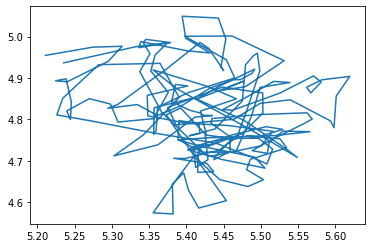

In [22]:
plt.plot(*dxy.T)

In [23]:
alluws2 = alluws - dxy[..., None, None]
tmean2 = alluws2.mean(axis=0).compute()
timedispl2 = np.linalg.norm(alluws2-tmean2, axis=1)[:, 200:-200, 200:-200].mean(axis=(-1, -2)).compute()

In [24]:
average_displ2 = np.linalg.norm(alluws2-tmean2, axis=1).mean(axis=0).compute()

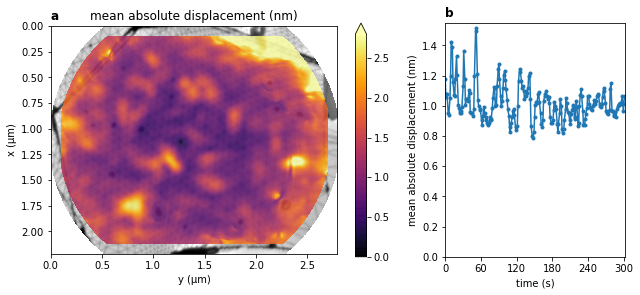

In [25]:
fig, axs = plt.subplots(ncols=2, figsize=[9, 4.2], gridspec_kw=dict(width_ratios=[2, 1]))
im = axs[0].imshow(ndatag[0].T, cmap='gray', vmax=clim2[1], vmin=clim2[0])
extent = np.array(im.get_extent())*NMPERPIXEL/1e3
im.set_extent(extent)

im = axs[0].imshow(np.where(mask, average_displ2, np.nan).T*NMPERPIXEL,
                   vmin=0, vmax=2.8,
                   cmap='inferno', alpha=0.85, extent=extent)


plt.colorbar(im, extend='max', ax=axs[0])

axs[0].set_ylabel('x (μm)')
axs[0].set_xlabel('y (μm)')
axs[0].set_title('mean absolute displacement (nm)')
axs[1].plot(np.array([np.timedelta64(dt, 's') for dt in dts]), timedispl2*NMPERPIXEL, marker='.')
#axs[1].plot(np.array([np.timedelta64(dt, 's') for dt in dts]), timedispl2*NMPERPIXEL)
plt.margins(x=0)
axs[1].set_ylabel('mean absolute displacement (nm)')
axs[1].set_xlabel('time (s)')
axs[1].set_ylim(0, None)
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(60))
for ax, l in zip(axs, 'ab'):
    ax.set_title(l, loc='left', fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join('figures', 'SI_dynamics_statistics.pdf'), dpi=600)

## Generate movie

(Not part of the publication)

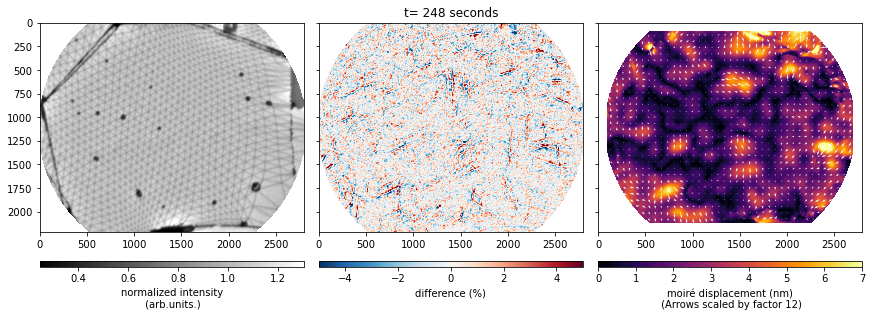

In [26]:

fig, ax = plt.subplots(ncols=3, figsize=[12, 5], constrained_layout=True, sharex=True)
im = [None]*3
#k = 123
k = 178
xx, yy = np.mgrid[0:ndata[k].shape[0], 0:ndata[k].shape[1]]*NMPERPIXEL
a = 20
im[0] = ax[0].imshow(ndatag[k].T, cmap='gray', vmax=clim2[1], vmin=clim2[0])
cbar = plt.colorbar(im[0], ax=ax[0], orientation='horizontal', shrink=1)
cbar.ax.set_xlabel('normalized intensity\n (arb.units.)')
im[1] = ax[1].imshow(100*(ndata[k] - ndata[0]).T, cmap='RdBu_r', vmax=100*clim[0], vmin=100*clim[1])
ax[1].set_title(f"t= {dts[k]}")
cbar1 = plt.colorbar(im[1], ax=ax[1], orientation='horizontal', shrink=1)
cbar1.ax.set_xlabel('difference (%)')
uwdiff = -1*(uws[2]-uws[0])*NMPERPIXEL
#uwdiff = (unew-uws_old[0])*NMPERPIXEL
uwdiff = np.where(mask, uwdiff, np.nan)
im[2] = ax[2].imshow(np.linalg.norm(uwdiff, axis=0).T, cmap='inferno', vmax=7, vmin=0)
a = 30
arrow_scale = 12
Q = ax[2].quiver(xx[::a, ::a], yy[::a, ::a], *uwdiff[:, ::a, ::a],
                 color='white', angles='xy', scale_units='xy', scale=1/arrow_scale)
cbar2 = plt.colorbar(im[2], ax=ax[2], orientation='horizontal', shrink=1)
cbar2.ax.set_xlabel(f'moiré displacement (nm)\n (Arrows scaled by factor {arrow_scale})')
for imi in im:
    imi.set_extent(np.array(imi.get_extent())*NMPERPIXEL)
for axi in ax[1:]:
    axi.tick_params(axis='y', which='both', labelleft=False, labelright=False)

In [27]:
def update(i):
    im[0].set_data(ndatag[i].T)
    im[1].set_data(100*(ndata[i] - ndata[0]).T)
    ax[1].set_title(f"t= {dts[i]}")
    unew = alluws[i].compute()
    uwdiff = -1*(unew-uws[0])*NMPERPIXEL
    uwdiff = np.where(mask, uwdiff, np.nan)
    im[2].set_data(np.linalg.norm(uwdiff, axis=0).T)
    Q.set_UVC(*uwdiff[:, ::a, ::a])
    if (i % 10) == 0:
        print(i)
    else:
        print(i, end=' ')
    return im + [Q]


ani = animation.FuncAnimation(fig, update, interval=200,
                              blit=True, save_count=ndata.shape[0])
ani.save(os.path.join(f'deformationcum_t_sigma={tsigma}_interval=200_cuda.mp4'),
         dpi=300)

0
0
0
1 2 3 4 5 6 7 8 9 10
11 12 13 14 15 16 17 18 19 20
21 22 23 24 25 26 27 28 29 30
31 32 33 34 35 36 37 38 39 40
41 42 43 44 45 46 47 48 49 50
51 52 53 54 55 56 57 58 59 60
61 62 63 64 65 66 67 68 69 70
71 72 73 74 75 76 77 78 79 80
81 82 83 84 85 86 87 88 89 90
91 92 93 94 95 96 97 98 99 100
101 102 103 104 105 106 107 108 109 110
111 112 113 114 115 116 117 118 119 120
121 122 123 124 125 126 127 128 129 130
131 132 133 134 135 136 137 138 139 140
141 142 143 144 145 146 147 148 149 150
151 152 153 154 155 156 157 158 159 160
161 162 163 164 165 166 167 168 169 170
171 172 173 174 175 176 177 178 179 180
181 182 183 184 185 186 187 188 189 190
191 192 193 194 195 196 197 198 199 200
201 202 203 204 205 206 207 208 209 210
211 212 213 214 215 216 

## Generate Supplementary Figure 6

In [29]:
transpose = True
xa, ya = 350, 200
xslice, yslice = slice(xa, xa+655-250), slice(ya, ya+910-550)
xx, yy = np.mgrid[xslice, yslice]
xx -= xa
yy -= ya
xx = xx*NMPERPIXEL
yy = yy*NMPERPIXEL


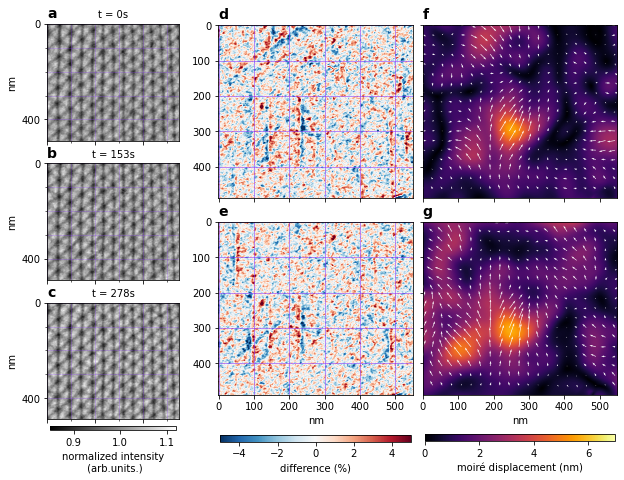

In [34]:
if transpose:
    fig = plt.figure(figsize=[8.5, 6.5], constrained_layout=True)
    gs = fig.add_gridspec(1, 2, width_ratios=[1.3, 3])
    gs0 = gs[0].subgridspec(3, 1)
    gs1 = gs[1].subgridspec(2, 2)
    axs = gs1.subplots(sharex=True, sharey=True).T
else:
    fig = plt.figure(figsize=[6.5, 8], constrained_layout=True)
    gs = fig.add_gridspec(2, 1, height_ratios=[1.3, 3])
    gs0 = gs[0].subgridspec(1, 3)
    gs1 = gs[1].subgridspec(2, 2)
    axs = gs1.subplots(sharex=True, sharey=True)

clim = np.nanquantile(ndata-ndata[0], [0.9999, 0.0001])
clim = [0.05, -0.05]

oaxs = gs0.subplots(sharey=True, sharex=True)
for a in oaxs:
    a.set_xticklabels([])

for i, k in enumerate(ks):
    im = oaxs[i].imshow(ndatag[k, xslice, yslice].T, cmap='gray')
    im.set_extent(np.array(im.get_extent())*NMPERPIXEL)
    oaxs[i].xaxis.set_minor_locator(ticker.MultipleLocator(100))
    oaxs[i].yaxis.set_minor_locator(ticker.MultipleLocator(100))
    oaxs[i].yaxis.set_major_locator(ticker.MultipleLocator(400))
    oaxs[i].xaxis.set_major_locator(ticker.MultipleLocator(200))
    oaxs[i].grid(color=glasbey[1], alpha=0.3, which='both')
    oaxs[i].set_title(f"t = {dts[k].astype(int)}s", fontsize='medium')
    oaxs[i].set_ylabel('nm')
    if i == 2:
        cbar = plt.colorbar(im, ax=oaxs, orientation='horizontal', shrink=0.81, pad=0.01)
        cbar.ax.set_xlabel('normalized intensity\n (arb.units.)')
    if i > 0:
        im = axs[0, i-1].imshow(100*(ndata-ndata[0])[k, xslice, yslice].T,
                                cmap='RdBu_r', vmax=100*clim[0], vmin=100*clim[1])
        im.set_extent(np.array(im.get_extent())*NMPERPIXEL)
        axs[0, i-1].xaxis.set_minor_locator(ticker.MultipleLocator(100))
        axs[0, i-1].yaxis.set_minor_locator(ticker.MultipleLocator(100))
        axs[0, i-1].grid(color=glasbey[1], alpha=0.7, which='both')
        if i == 2:
            cbar = plt.colorbar(im, ax=axs[0, :], orientation='horizontal', shrink=0.98, pad=0.02)
            cbar.ax.set_xlabel('difference (%)')
            axs[0, i-1].set_xlabel('nm')
            axs[1, i-1].set_xlabel('nm')
        uwdiff = -1*(uws[i]-uws[0])[:, xslice, yslice]*NMPERPIXEL
        im = axs[1, i-1].imshow(np.linalg.norm(uwdiff, axis=0).T, cmap='inferno', vmax=7., vmin=0)
        im.set_extent(np.array(im.get_extent()) * NMPERPIXEL)
        a = 20
        axs[1, i-1].quiver(xx[::a, ::a], yy[::a, ::a], *uwdiff[:, ::a, ::a],
                           color='white', angles='xy', scale_units='xy', scale=1/8)
        if i == 2:
            cbar = plt.colorbar(im, ax=axs[1, :], orientation='horizontal', shrink=0.98, pad=0.02)
            cbar.ax.set_xlabel('moiré displacement (nm)')

title_kwargs = dict(fontsize=14, fontweight='bold', loc='left')
for ax, label in zip(axs.flat, 'defg'):
    ax.set_title(label, **title_kwargs)
for ax, label in zip(oaxs.flat, 'abc'):
    ax.set_title(label, **title_kwargs)
    
fig.set_constrained_layout_pads(w_pad=1 / 72, h_pad=1 / 72, hspace=0.0, wspace=1.0/72)
plt.savefig(os.path.join('figures', f'Sdynamics_t_sigma={tsigma}_v2_1.pdf'), dpi=300)

## Generate Supplementary Figure 7

In [35]:
props0 = da.compute(props[0])[0]

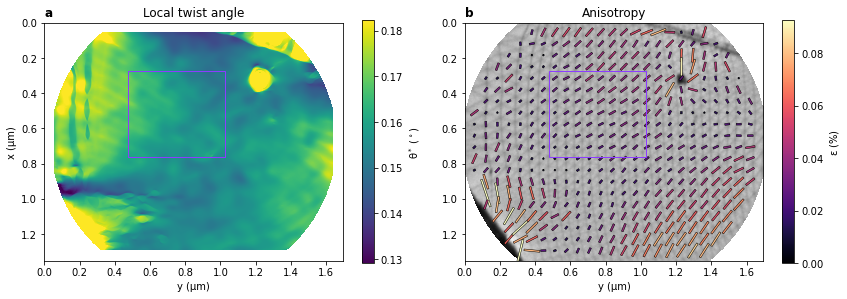

In [36]:
loc_im = ndatag[ks[0]]
fig, axs = plt.subplots(ncols=2, figsize=[12, 4])

im = axs[0].imshow(np.where(mask, props0[..., 0], np.nan).T,
                   vmin=np.quantile(props0[..., 0], 0.001),
                   vmax=np.quantile(props0[..., 0], 0.97)
                   )

im.set_extent(np.array(im.get_extent())*NMPERPIXEL/1000)
plt.colorbar(im, ax=axs[0], label='$\\theta^*$ ($^\\circ$)')

im = axs[1].imshow(loc_im.T, cmap='gray')

epscolor = props0[..., 2]*100
angle = np.deg2rad(props0[..., 1])  # % 180
magnitude = epscolor

kx = magnitude * np.cos(angle)
ky = magnitude * np.sin(angle)
a = 48
xxl, yyl = np.meshgrid(np.arange(loc_im.shape[0]),
                       np.arange(loc_im.shape[1]),
                       indexing='ij')

kx = np.where(mask, kx, np.nan)
ky = np.where(mask, ky, np.nan)
Q = axs[1].quiver((xxl[dr:-dr:a, dr:-dr:a])*NMPERPIXEL/1000,
                  (yyl[dr:-dr:a, dr:-dr:a])*NMPERPIXEL/1000,
                  ky[dr:-dr:a, dr:-dr:a],
                  kx[dr:-dr:a, dr:-dr:a],
                  np.clip(magnitude[dr:-dr:a, dr:-dr:a], 0, np.quantile(magnitude, 0.98)),
                  cmap='magma',
                  norm=mpl.colors.Normalize(vmin=0),
                  angles='xy', scale_units='xy',
                  width=0.006, pivot='mid',
                  ec='black', linewidth=0.5,
                  headlength=0., headwidth=0.5, headaxislength=0)
plt.colorbar(Q, ax=axs[1], label='$\\epsilon$ (%)')  # , ticks=[1, 1.1, 1.2])
for ax in axs:
    rect = mpl.patches.Rectangle(np.array([xslice.start, yslice.start]) * NMPERPIXEL/1000,
                                 (xslice.stop-xslice.start) * NMPERPIXEL/1000,
                                 (yslice.stop-yslice.start) * NMPERPIXEL/1000,
                                 facecolor='none', edgecolor=glasbey[1])
    ax.add_patch(rect)
im.set_extent(np.array(im.get_extent())*NMPERPIXEL/1000)
axs[0].set_title('Local twist angle')
axs[1].set_title('Anisotropy')
for ax, l in zip(axs, 'ab'):
    ax.set_title(l, loc='left', fontweight='bold')
    ax.set_xlabel('y (μm)')
axs[0].set_ylabel('x (μm)')
plt.tight_layout()
plt.savefig(os.path.join('figures', 'SFig_dynamics_theta_and_aniso.pdf'))